<a href="https://colab.research.google.com/github/Jihyun13579/ESAA/blob/main/1218(%EC%9B%94)_%EA%B3%BC%EC%A0%9C_%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%94%A5%EB%9F%AC%EB%8B%9D_%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C_ch4_5_pg_229~240_%ED%95%84%EC%82%AC_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1218(월) 과제_파이썬 딥러닝 텐서플로 ch4. 7 pg. 229~240 필사
### 2129014 박지현

# PART 04. 합성곱 신경망(CNN)

## PART 04.07. 이미지 분할(Segmentation)

이미지 분할=세그멘테이션: 이미지를 구성하는 모든 픽셀에 대해 픽셀 단위로 분류하는 것
- 모든 픽셀은 어떤 클래스에 속한다.
- ex. 배경 클래스&객체 클래스로 구성된 이미지 > 모든 픽셀은 배경 or 객체 중 하나로 분류됨
- 모든 픽셀에 대한 정답 클래스를 레이블 처리한 데이터셋 가지고 딥러닝 모델 훈련 > 정답 클래스 알지 못하는 새로운 이미지에 대해서도 배경과 객체 분리 가능

이미지 분할의 종류
- 의미 분할(semantic segmentation) : 같은 범주의 여러 객체를 하나의 범주로 묶어서 구분
- 인스턴스 분할(instance segmentation): 같은 범주에 속하더라도 서로 다른 객체를 구분

![스크린샷 2023-12-22 174553.png](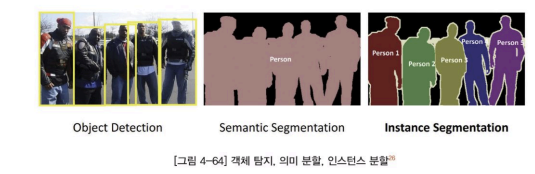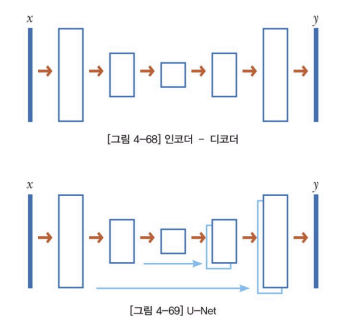)

### 7-1. 데이터셋 준비
- 사용할 데이터셋 : Oxford-IIIT Pet Dataset
> 반려동물의 이미지 및 분류 레이블, 각 이미지를 구성하는 픽셀 단위의 마스크로 구성되어 있음
 - 마스크: 각 픽셀에 대한 범주 레이블, 각 픽셀은 다음 세 범주 중 하나에 속함



1. 영상 처리를 위한 OpenCV 비롯한 필수 라이브러리 불러오기

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import cv2
from tqdm.notebook import tqdm
import tensorflow_datasets as tfds
from google.colab.patches import cv2_imshow

2. 모델 학습에 필요한 입력 이미지의 크기와 팍습 파라미터 설정하기
- 모델의 세부 튜닝 작업을 효율적으로 하기 위해 주요 파라미터 따로 정리함

In [2]:
# 이미지 크기
img_w = 128
img_h = 128
img_c = 3
img_shape = (img_w, img_h, img_c)

# 모델 학습
epoch_num = 5
learning_rate = 0.0001
buffer_size = 1000
batch_size = 16

3. 텐서플로 데이터셋에서 옥스포드 반려동물 데이터 볼러오기 & 메타 정보 가져와서 info 변수에 저장하기

In [3]:
# 텐서플로 데이터셋 로드
ds_str='oxford_iiit_pet'
ds,info=tfds.load(name=ds_str,with_info=True)

4. 원본 이미지와 분할 마스크를 전처리하는 함수 정의하기

In [4]:
# 이미지 전처리 함수
def preprocess_image(ds):
    # 원본 이미지
    img=tf.image.resize(ds['image'],(img_w,img_h))
    img=tf.cast(img,tf.float32)/255.0
    # 분할 마스크
    mask=tf.image.resize(ds['segmentation_mask'],(img_w,img_h))
    mask=tf.cast(mask,tf.int32)
    mask=mask-1
    return img,mask

5. 앞에서 정의한 전처리 함수를 훈련 셋, 테스트 셋에 매핑해준 후 미니 배치로 분할하기

In [5]:
# 데이터 전처리 파이프라인
train_ds=ds['train'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)
test_ds=ds['test'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)
print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.int32, name=None))>


6. 샘플 배치를 한 개 선택하기
- 한 개의 배치에는 16개의 샘플 이미지와 마스크 이미지가 들어가 있음

In [6]:
# 샘플 배치 선택
img,mask=next(iter(train_ds))
len(img)

16

7. 배치에서 첫 번째 이미지 출력하기
- 0~1 사이의 값이므로 255 곱해서 정규화 이전의 원래 값으로 복원 필요

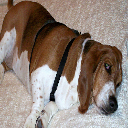

In [7]:
# 샘플 이미지 출력
img=np.array(img[0])*255.0
img=cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
cv2_imshow(img)

8. 마스크 이미지 출력하기
- 마스크 값의 범위: 0~2 > 2로 나눈 다음 255 곱하면 RGB 이미지로 표현 가능

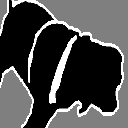

In [8]:
# 샘플 마스크 출력
mask=np.array(mask[0]/2)*255.0
cv2_imshow(mask)

### 7-2. U-Net 모델(인코더-디코더)

사전 학습된 VGG16 모델은 인코더로 활용하는 U-Net 모델을 만들어보기
- VGG16: 이미지넷 경진 대회를 통해 성능이 검증된 모델
- 데이터 개수가 충분하고, 시간이 충분하다면, 사전 학습된 모델 없이 U-Net 구성하여 학습을 진행해도 좋음




1. VGG16 모델은 최종 레이어를 제외한 채 불러오기

In [9]:
# VGG 16 모델
base_model=tf.keras.applications.VGG16(input_shape=img_shape,include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


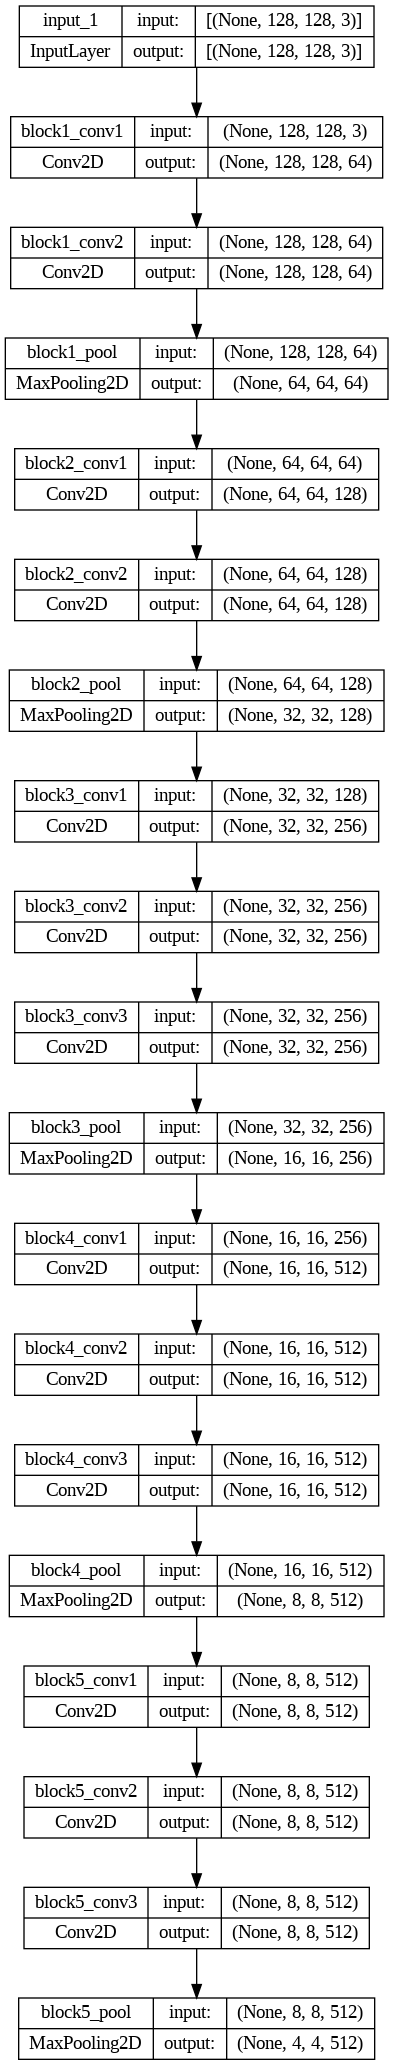

In [10]:
# 모델 구조
tf.keras.utils.plot_model(base_model,show_shapes=True)

In [11]:
# VGG 중간 레이어 출력 텐서를 지정
f_model=tf.keras.Model(inputs=[base_model.input],
                       outputs=[
                           base_model.get_layer(name='block5_conv3').output,
                           base_model.get_layer(name='block4_conv3').output,
                           base_model.get_layer(name='block3_conv3').output,
                           base_model.get_layer(name='block2_conv2').output,
                           base_model.get_layer(name='block1_conv2').output
                       ])

In [12]:
# 파라미터 고정
f_model.trainable=False
# U-Net 구조로 모델 정의
i=tf.keras.Input(shape=img_shape)
out_8_8_512,out_16_16_512,out_32_32_256,out_64_64_128,out_128_128_64=f_model(i)

In [13]:
out=tf.keras.layers.Conv2DTranspose(512,3,strides=2,padding='same')(out_8_8_512)
out=tf.keras.layers.Add()([out,out_16_16_512])

out=tf.keras.layers.Conv2DTranspose(256,3,strides=2,padding='same')(out)
out=tf.keras.layers.Add()([out,out_32_32_256])

out=tf.keras.layers.Conv2DTranspose(128,3,strides=2,padding='same')(out)
out=tf.keras.layers.Add()([out,out_64_64_128])

out=tf.keras.layers.Conv2DTranspose(64,3,strides=2,padding='same')(out)
out=tf.keras.layers.Add()([out,out_128_128_64])

out=tf.keras.layers.Conv2DTranspose(3,3,activation='elu',padding='same')(out)
out=tf.keras.layers.Dense(3,activation='softmax')(out)
unet_model=tf.keras.Model(inputs=[i],outputs=[out])

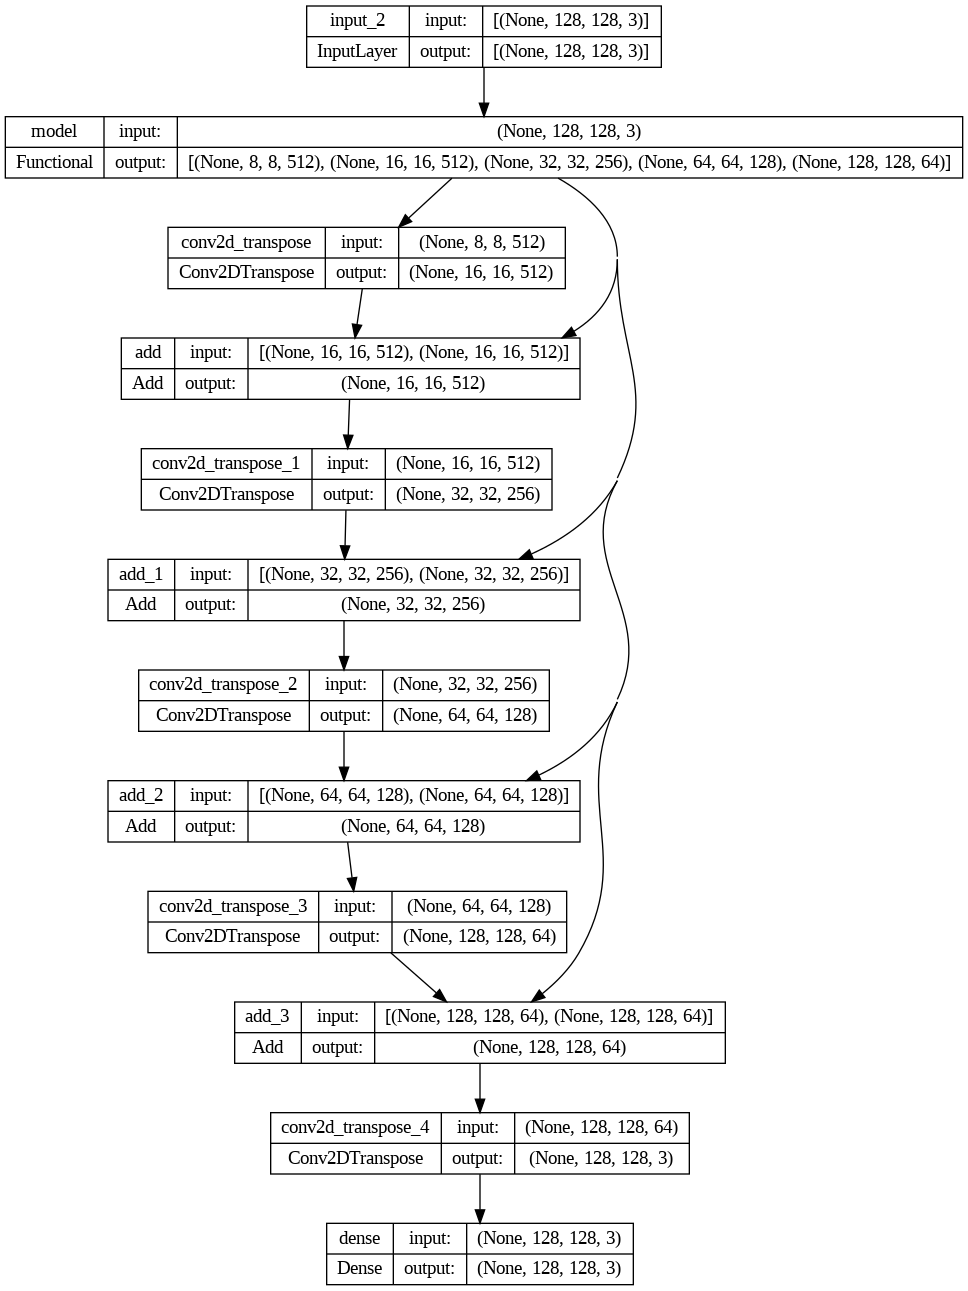

In [14]:
# 모델 구조 시각화
tf.keras.utils.plot_model(unet_model,show_shapes=True)

In [15]:
# 모델 요약
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model (Functional)          [(None, 8, 8, 512),          1471468   ['input_2[0][0]']             
                              (None, 16, 16, 512),        8                                       
                              (None, 32, 32, 256),                                                
                              (None, 64, 64, 128),                                                
                              (None, 128, 128, 64)]                                               
                                                                                            

In [ ]:
# 모델 컴파일 훈련
loss_f=tf.losses.SparseCategoricalCrossentropy()
opt=tf.optimizers.Adam(learning_rate)
unet_model.compile(optimizer=opt,loss=loss_f,metrics=['accuracy'])
unet_model.fit(train_ds,batch_size=batch_size,epochs=epoch_num)

Epoch 1/5
 61/230 [======>.......................] - ETA: 17:09 - loss: 1.2875 - accuracy: 0.5538

In [ ]:
# 1개 배치
img,mask=next(iter(test_ds))
# 모델 예측
pred=unet_model.predict(img)
# 첫번째 미이지 분할 결과를 출력
pred_img=np.argmax(pred[0],-1)
plt.imshow(pred_img)

In [ ]:
# 첫번째 이밎 정답 마스크 출력
plt.imshow(np.reshape(mask[0],(128,128)))